In [45]:
#import os
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import pickle
from PIL import Image
from numpy import asarray


ModuleNotFoundError: No module named 'winsound'

In [2]:
# find and read image
images_dir = cv2.imread("/Users/atemkuh/Documents/GitHub/Mask-Finder/data/with_mask/2135.jpg")

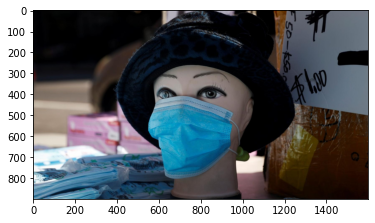

In [3]:
#view image and convert into RGB using cv2
plt.imshow(cv2.cvtColor(images_dir, cv2.COLOR_BGR2RGB))

In [4]:
#images_dir.shape

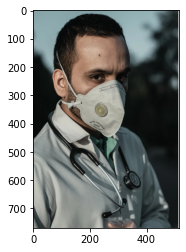

In [5]:
#loop through dataset
Images_directory = "/Users/atemkuh/Documents/GitHub/Mask-Finder/data"
Classes = ["with_mask","without_mask"]
for category in Classes:
    path = os.path.join(Images_directory, category)
    for img in os.listdir(path):
        images_dir = cv2.imread(os.path.join(path,img))
        
        plt.imshow(cv2.cvtColor(images_dir, cv2.COLOR_BGR2RGB))
        plt.show()
        # stop processing after first image
        break
    break
    

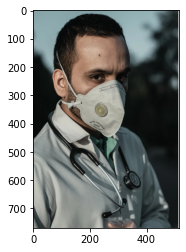

In [6]:
#resize images using imageNet 
img_size = 224
new_img_array=cv2.resize(images_dir,(img_size,img_size))
plt.imshow(cv2.cvtColor(images_dir, cv2.COLOR_BGR2RGB))
plt.show()


In [7]:
# convert images to arrays 
training_data = []

def create_training_data():
    for category in Classes:
        path = os.path.join(Images_directory,category)
        class_num = Classes.index(category)
        
        print("category")
        for img in os.listdir(path):
            try:
               # print(img, ", ", path)
                images_dir    = cv2.imread(os.path.join(path,img))
                
                new_img_array = cv2.resize(images_dir,(img_size,img_size))
                
                training_data.append([new_img_array, class_num])
              #  print(len(training_data))
                
            except Exception as e:
                print(e)
                


In [8]:
create_training_data()

category
category


In [9]:
print(len(training_data))

100


In [10]:
random.shuffle(training_data)

In [11]:
X =[]
y=[]

for features,label in training_data:
    X.append(features)
    y.append(label)
# convert to np
X = np.array(X).reshape(-1,img_size,img_size,3)

In [12]:
X.shape

(100, 224, 224, 3)

In [13]:
X=X/255.0;

In [14]:
y[10]

1

In [15]:
Y=np.array(y)

In [16]:
#pickle x
pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()
#pickle y
pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [17]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [18]:
#create and train deep learning model
#pre trained model
model = tf.keras.applications.MobileNet()
model.summary() #Total params: 4,253,864

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [19]:
# use existing solution by implementing transfer learning "tuning", "weights"
base_input = model.layers[0].input

In [20]:
base_output = model.layers[-4].output

In [21]:
Flatten_layer =  layers.Flatten()(base_output)
#classifier  can either be 0 or 1
final_output = layers.Dense(1)(Flatten_layer)
final_output = layers.Activation('sigmoid')(final_output)

In [22]:
#new model
new_model=keras.Model(inputs = base_input, outputs = final_output)
new_model.summary()## display the sum of the new model #Total params: 3,229,889

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [23]:
#setup up configuration os classes('with_mask','without_mask')

#compile new model
new_model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [24]:
new_model.fit (X,Y, batch_size = 32, epochs = 5, validation_data = (X,Y,))

#model.fit(x_train, y_train, batch_size = 32, epochs = 5, validation_data = (x_val, y_val))

Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 38s 380ms/sample - loss: 0.2072 - accuracy: 0.9200 - val_loss: 2.5390 - val_accuracy: 0.5700
Epoch 2/5
100/100 [==============================] - 20s 195ms/sample - loss: 0.0691 - accuracy: 0.9900 - val_loss: 0.3474 - val_accuracy: 0.9000
Epoch 3/5
100/100 [==============================] - 20s 200ms/sample - loss: 0.1896 - accuracy: 0.9800 - val_loss: 0.1769 - val_accuracy: 0.9700
Epoch 4/5
100/100 [==============================] - 20s 203ms/sample - loss: 0.0968 - accuracy: 0.9800 - val_loss: 0.1107 - val_accuracy: 0.9800
Epoch 5/5
100/100 [==============================] - 25s 254ms/sample - loss: 0.0115 - accuracy: 0.9900 - val_loss: 0.0799 - val_accuracy: 0.9800


In [67]:
#save model
new_model.save('new_model.h5')

In [53]:
#import trained model using tf.keras.models.load_model
new_model = tf.keras.models.load_model('new_model.h5')

In [54]:
#predictions with mask
frame = cv2.imread('demo_mask.jpg')
#frame=cv2.imread('demo_without_mask.jpg') # switch images to determine prediction

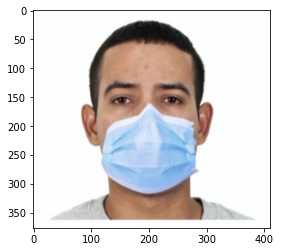

In [55]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [56]:
final_img =cv2.resize(frame,(224,224))
final_img =np.expand_dims(final_img, axis=0)
final_img = final_img/255.0

In [57]:
# predictions with mask is close to 0.00 or negative
Predictions = new_model.predict(final_img)
Predictions 

array([[0.00039793]], dtype=float32)

In [58]:
frame=cv2.imread('demo_without_mask.jpg')
#frame = cv2.imread("/Users/atemkuh/Documents/GitHub/Mask-Finder/data/without_mask/real_01071.jpg")

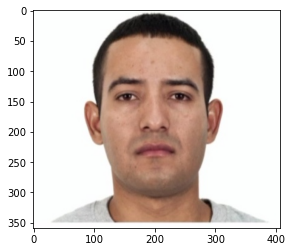

In [59]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [60]:
#get haarcascades feature detector with prestore faces and features
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
#convert image from BGR to gray
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
gray.shape

(359, 407)

In [61]:
# to detect faces

faces = faceCascade.detectMultiScale(gray,1.1,4) # detects face and gives the four corners of the face

for (x,y,w,h) in faces:
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = frame[y:y + h, x:x + w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255),2) # DRAWS A RECTANGLE ON THE FACE
    
    facess = faceCascade.detectMultiScale(roi_gray)
    
    if len(facess)==0:
        
        print("No Face Detected")
    else:
        for (ex, ey, ew, eh) in facess:
            
            face_roi = roi_color[ey: ey + eh, ex: ex + ew] # CROPS FACE

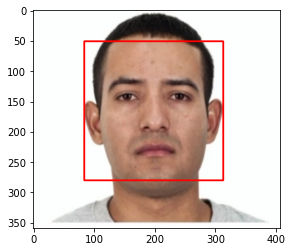

In [62]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))# DETECT FACE AND PLACE A RECTANGLE ON THE FACE

In [63]:
# crop face
#plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))# crop our region of interest (ROI)

In [64]:
final_img =cv2.resize(face_roi,(224,224))
final_img =np.expand_dims(final_img, axis=0)
final_img = final_img/255.0

In [65]:
# predictions without mask is close to 1 or positive
Predictions = new_model.predict(final_img)
Predictions 

array([[1.]], dtype=float32)

In [66]:
import cv2
path = "haarcascade_frontalface_default.xml"
font_scale=1.5
font = cv2.FONT_HERSHEY_PLAIN

rectangle_bgr = (255,255,255)
img = np.zeros((500,500))
text="some. text in a box!"#text in a box
#width and height
(text_width, text_height) = cv2.getTextSize(text,font,fontScale=font_scale, thickness=1)[0]
#set text position

text_offset_x = 10
text_offset_y = img.shape[0]-25

#box coords

box_coords =((text_offset_x, text_offset_y),(text_offset_x + text_width + 2,text_offset_y - text_height - 2))
cv2.rectangle (img,box_coords[0], box_coords[1],rectangle_bgr, cv2.FILLED)
cv2.putText(img,text,(text_offset_x, text_offset_y), font, fontScale=font_scale, color = (0,0,0), thickness = 1)
#setup video capture

cap = cv2.VideoCapture(1)

if not cap.isOpened():
    cap = cv2.VideoCapture(0)#number of camera 0 for one camera present
if not cap.isOpened():
    raise IOError("Please check webcam")

while True:
    
    ret,frame = cap.read()
    
    faceCascade =cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w] 
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),2)
        
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess)==0:
            print ("No face detected")
        else:
            # crop our region of interest (ROI)
            
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex + ew]
                
                
                
                
    final_image = cv2.resize(face_roi,(224,224))
    
    final_image= np.expand_dims(final_image,axis =0)
    
    final_image=final_image/255.0
    
    font=cv2.FONT_HERSHEY_SIMPLEX
    
    Predictions = new_model.predict(final_image)
    
    font_scale=1.5
    
    font=cv2.FONT_HERSHEY_PLAIN
    
    if (Predictions>0):
        
        status = "NO Mask"
        x1,y1,w1,h1 = 0,0,175,75
        
       # cv2.rectangle(frame, (x1,x1),(x1+w1, y1+h1), (0,0,0), -1)
        
        cv2.putText (frame,status, (x1+int (w1/10), y1+int (h1/2)), cv2.FONT_HERSHEY_SIMPLEX,0.7, (0,0,255),2)
        
        #cv2.putText(frame,status,(100,150), font,3, (0,0,255),2,cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y),(x+w,y+h),(0,0,255))
        
        
    else:
        status = "Thank You"
        
        x1,y1,w1,h1 = 0,0,175,75
        
       # cv2.rectangle(frame, (x1,x1),(x1+w1,y1+h1), (0,0,0), -1)
        
        cv2.putText (frame,status, (x1+int(w1/10),y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX,0.7, (0,255,0),2)
        
       # cv2.putText(frame,status,(100,150),font,3,(0,255,0),2,cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y),(x+w,y+h),(0,255,0))
        
        cv2.imshow('Mask Finder', frame)
        if cv2.waitKey(2)& 0xFF ==ord('q'):
            break
cap.release()
cv2.waitkey(0)
cv2.destroyAllWindows()
        
            
    #     

No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detect

KeyboardInterrupt: 

In [ ]:
cap.release()
cv2.destroyAllWindows()